**Lab 14 – Gradient boosting and ensemble learning**

_This notebook contains the sample from https://github.com/ageron/handson-ml3/blob/main/07_ensemble_learning_and_random_forests.ipynb, https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn and https://github.com/catboost/tutorials

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math604/blob/master/static_files/presentations/14_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math604/blob/master/static_files/presentations/14_ensemble.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [ ]:
!pip install scikeras[tensorflow] -qq
!pip install xgboost -U -qq
!pip install lightgbm -U -qq
!pip install catboost -U
!pip install shap

     |████████████████████████████████| 564 kB 5.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import time

import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #Should be enabled when using DeepSHAP, see https://github.com/slundberg/shap/issues/2189
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

import shap
shap.initjs() 

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

In [ ]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    #plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

## Voting classifier

`Scikit-Learn` provides a `VotingClassifier` class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier, that’s it! Let’s try it on the moons dataset (this is a toy dataset for binary classification in which the data points are shaped as two interleaving crescent moons). We will load and split the moons dataset into a training set and a test set, then we’ll create and train a voting classifier composed of three diverse classifiers:

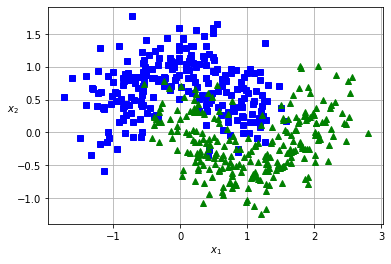

In [ ]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plot_dataset(X, y)

Here we use [`SciKeras`](https://github.com/adriangb/scikeras) to wrap kerase model into `Scikit-Learn`.

In [ ]:
def get_model():
    model= keras.models.Sequential([keras.layers.Dense(30,activation='relu',input_shape=[2]),
                      keras.layers.Dense(20,activation='relu'),
                      keras.layers.Dense(1,activation='sigmoid')
                           ])
    model.compile(optimizer='NAdam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [ ]:
dense_model = KerasClassifier(model=get_model, epochs=200, verbose=False)

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42)),
        ('dense', dense_model)
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('dense',
                              KerasClassifier(epochs=200, model=<function get_model at 0x7f9198a875f0>, verbose=False))])

When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead. For example, let’s look at each fitted classifier’s accuracy on the test set:

In [ ]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896
dense = 0.896


When you call the voting classifier’s `predict()` method, it performs hard voting. For example, the voting classifier predicts class 1 for the first instance of the test set, because 3 out of 4 classifiers predict that class:

In [ ]:
voting_clf.predict(X_test[:1]),  [clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

(array([1]), [array([1]), array([1]), array([0]), array([1])])

Now let’s look at the performance of the voting classifier on the test set:

In [ ]:
voting_clf.score(X_test, y_test)

0.88

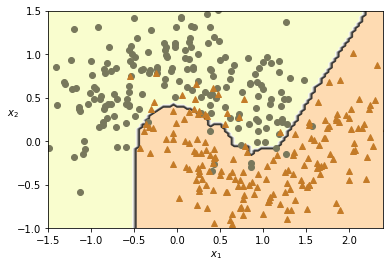

In [ ]:
plot_decision_boundary(voting_clf, X_train, y_train)

If all classifiers are able to estimate class probabilities (i.e., they all have a `predict_proba()` method), then you can tell `Scikit-Learn` to predict the class with the **highest class probability, averaged over all the individual classifiers.** This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is set the voting classifier’s voting hyperparameter to "soft", and ensure that all classifiers can estimate class probabilities. 

This is not the case for the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). Let’s try that:

In [ ]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.912

We reach 91.2% accuracy simply by using soft voting, not bad!

For stacking neural ntwork model, you can refer to https://ensemble-pytorch.readthedocs.io/en/latest/ for more details.

## Stacking

`Scikit-Learn` provides two classes for stacking ensembles: `StackingClassifier` and `StackingRegressor`. For example, you can replace the `VotingClassifier` you used on the moons dataset with a `StackingClassifier`:

In [ ]:
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

For each predictor, the stacking classifier will call `predict_proba()` if available, or it will fallback to `decision_function()` if available, or as a last resort it will call `predict()`. If you don’t provide a final estimator, `StackingClassifier` will use `LogisticRegression`, and `StackingRegressor` will use `RidgeCV`.

In [ ]:
stacking_clf.score(X_test, y_test)

0.928

You get 92.8% accuracy! which is a bit better than the voting classifier using soft voting, which got 92%.

## Baaging and Pasting

`Scikit-Learn` offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of 500 **Decision Tree classifiers**:⁠ each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`). The `n_jobs` parameter tells `Scikit-Learn` the number of CPU cores to use for training and predictions, and –1 tells `Scikit-Learn` to use all available cores.

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=42)

Notice that the `BaggingClassifier` automatically performs **soft voting** instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with Decision Tree classifiers.

We compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

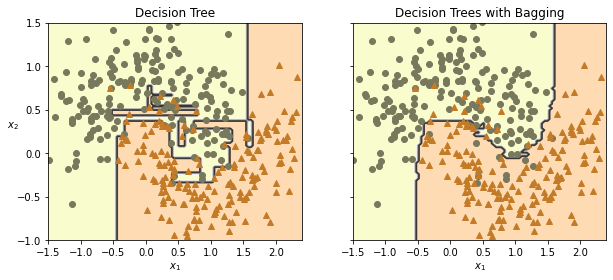

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

### Out-of-Bag evaluation

It can be shown mathematically that only about 63% of the training instances are sampled on average for each predictor.⁠6 The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors. The following calculate this number when `m=1000`:

In [ ]:
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


In `Scikit-Learn`, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available in the `oob_score_` attribute:

In [ ]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to this oob evaluation, this `BaggingClassifier` is likely to achieve about 89.6% accuracy on the test set. Let’s verify this:

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

We get 92% accuracy on the test. The oob evaluation was a bit too pessimistic, a bit over 2% too low.

The `BaggingClassifier` class supports **sampling the features** as well. Sampling is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This technique is particularly useful when you are dealing with high-dimensional inputs (such as images). **Sampling both training instances and features is called the Random Patches method**.⁠ Keeping all training instances (by setting `bootstrap=False` and `max_samples=1.0`) but sampling features (by setting `bootstrap_features` to True and/or `max_features` to a value smaller than 1.0) is called the **Random Subspaces method**.⁠

### Random forest

Random Forest9 is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), **typically with `max_samples` set to the size of the training set.** Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and **optimized for Decision Trees** (similarly, there is a `RandomForestRegressor` class for regression tasks). The follwong `BaggingClassifier` is equivalent to random forest

```python
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)
```

The following code trains a Random Forest classifier with 500 trees, each limited to maximum 16 nodes, and using all available CPU cores:

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

You can also create an Extra-Trees classifier using `Scikit-Learn`’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class, except bootstrap defaults to False. Similarly, the `ExtraTreesRegressor` class has the same API as the RandomForestRegressor class, except bootstrap defaults to False.

## AdaBoost

Scikit-Learn uses a multiclass version of AdaBoost called `SAMME`⁠ (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function). When there are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 30 Decision Stumps using `Scikit-Learn`’s `AdaBoostClassifier` class (as you might expect, there is also an `AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1`—in other words, **a tree composed of a single decision node** plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

In [ ]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

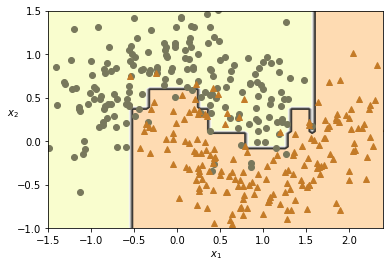

In [ ]:
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting

First, let’s generate a noisy quadratic dataset and fit a `DecisionTreeRegressor`to it:

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class (there’s also a `GradientBoostingClassifier` class for classification). Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimator`s). 

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.05, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called shrinkage.

To find the optimal number of trees, you could perform cross-validation using `GridSearchCV` or `RandomizedSearchCV`, as usual, but there’s a simpler way: if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help. This is simply early stopping, but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. Let’s train the ensemble using early stopping:

In [ ]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

If you set `n_iter_no_change` too low, training may stop too early and the model will underfit. But if you set it too high, it will overfit instead. We also set a fairly small learning rate and a high number of estimators, but the actual number of estimators in the trained ensemble is much lower, thanks to early stopping:

In [ ]:
gbrt_best.n_estimators_

92

When `n_iter_no_change` is set, the `fit(`) method automatically splits the training set into a smaller training set and a validation set: this allows it to evaluate the model’s performance each time it adds a new tree. The size of the validation set is controlled by the `validation_fraction` hyperparameter, which is 10% by default. The tol hyperparameter determines the maximum performance improvement that still counts as negligible. It defaults to 0.0001.

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called **Stochastic Gradient Boosting**.

## XGBoost

### Classification task

Here are the essential steps to build an XGBoost classification model in scikit-learn using cross-validation.

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

The following template is for building an XGBoost classifier

In [ ]:
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', 
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

1. `booster='gbtree'`: The booster is the base learner. It's the machine learning model that is constructed during every round of boosting. You may have guessed that 'gbtree' stands for gradient boosted tree, the XGBoost default base learner. It's uncommon but possible to work with other base learners, 

2. `objective='multi:softprob'`: Standard options for the objective can be viewed in the XGBoost official documentation, https://xgboost.readthedocs.io/en/latest/parameter.html, under Learning Task Parameters. The multi:softprob objective is a standard alternative to binary:logistic when the dataset includes multiple classes. It computes the probabilities of classification and chooses the highest one. If not explicitly stated, XGBoost will often find the right objective for you.

3. `max_depth=6`: The max_depth of a tree determines the number of branches each tree has. It's one of the most important hyperparameters in making balanced predictions. XGBoost uses a default of 6, unlike random forests, which don't provide a value unless explicitly programmed.

3. `learning_rate=0.1`: Within XGBoost, this hyperparameter is often referred to as eta. This hyperparameter limits the variance by reducing the weight of each tree to the given percentage. 

4. `n_estimators=100`: Popular among ensemble methods, `n_estimators` is the number of boosted trees in the model. Increasing this number while decreasing `learning_rate` can lead to more robust results.

In [ ]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}

### Regression task

Here are the essential steps to build an XGBoost regression model in scikit-learn using cross-validation.

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', 
                    learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [63.033 59.689 64.538 63.699 64.661]
RMSE mean: 63.124


In [ ]:
xgb.fit(X,y)
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

Without a baseline of comparison, we have no idea what that score means. Converting the target column, `y`, into a pandas DataFrame with the `.describe()` method will give the quartiles and the general statistics of the predictor column, as follows:

In [ ]:
pd.DataFrame(y).describe()

,0
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


A score of 63.124 is less than 1 standard deviation, a respectable result.

### Speed comparsion

Let's now compare `GradientBoostingClassifier` and `XGBoostClassifier` with the [exoplanet dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data) for its speed 

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv

--2022-05-21 11:00:29--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter04/exoplanets.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv [following]
--2022-05-21 11:00:29--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter04/exoplanets.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [text/plain]
Saving to: ‘exopla

In [ ]:
df = pd.read_csv('exoplanets.csv')
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

gbr = GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9874213836477987
Run Time: 248.6392641067505 seconds


In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
xg_reg = XGBClassifier(n_estimators=100, max_depth=2, random_state=42)

# class column has to start from 0 (as required since version 1.3.2).
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
# Fit xg_reg to training set
xg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = xg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 52.40076756477356 seconds


When it comes to big data, an algorithm six as fast can save weeks or months of computational time and resources! This advantage is huge in the world of big data. In the world of boosting, XGBoost is the model of choice due to its unparalleled speed and impressive accuracy.

### Hyperparameter

XGBoost has many hyperparameters. XGBoost base learner hyperparameters incorporate all decision tree hyperparameters as a starting point. There are gradient boosting hyperparameters, since XGBoost is an enhanced version of gradient boosting.

In [ ]:
!wget https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv

--2022-05-21 05:49:41--  https://github.com/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/raw/master/Chapter06/heart_disease.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv [following]
--2022-05-21 05:49:41--  https://media.githubusercontent.com/media/PacktPublishing/Hands-On-Gradient-Boosting-with-XGBoost-and-Scikit-learn/master/Chapter06/heart_disease.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11328 (11K) [text/plain]
Saving to: ‘he

In [ ]:
df = pd.read_csv('heart_disease.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
# Split data into X and y
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Before tuning hyperparameters, let's build a classifier so that we can obtain a baseline score as a starting point.

When fine-tuning hyperparameters, GridSearchCV and RandomizedSearchCV are the standard options. However, `cross_val_score` and `GridSearchCV/RandomizedSearchCV` do not split data the same way. One solution is to use `StratifiedKFold` whenever cross-validation is used.

A stratified fold includes the same percentage of target values in each fold. If a dataset contains 60% 1s and 40% 0s in the target column, each stratified test set contains 60% 1s and 40% 0s. When folds are random, it's possible that one test set contains a 70-30 split while another contains a 50-50 split of target values.

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# The 'binary:logistic' objective is standard for binary classification in determining the loss function
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
# Obtain scores of cross-validation
scores = cross_val_score(model, X, y, cv=kfold)

# Display accuracy
print('Accuracy:', np.round(scores, 2))

# Display mean accuracy
print('Accuracy mean: %0.2f' % (scores.mean()))

Accuracy: [0.85 0.72 0.74 0.82 0.78]
Accuracy mean: 0.78


The point here is to use the same folds to obtain new scores when fine-tuning hyperparameters with GridSearchCV and RandomizedSearchCV so that the comparison of scores is fair.

In [ ]:
def grid_search(params, random=False): 
    
    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, n_jobs=-1, random_state=42)
    else:
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    
    # Fit grid_reg on X_train and y_train
    grid.fit(X, y)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

The XGBoost hyperparameters presented here are not meant to be exhaustive, but they are meant to be comprehensive. For a complete list of hyperparameters, read the official documentation, XGBoost Parameters, at https://xgboost.readthedocs.io/en/latest/parameter.html.

#### learning_rate

`learning_rate` shrinks the weights of trees for each round of boosting. By lowering `learning_rate`, more trees are required to produce better scores. Lowering `learning_rate` prevents overfitting because the size of the weights carried forward is smaller.

A default value of 0.3 is used. Here is a starting range for `learning_rate` as placed inside our grid_search function:

In [ ]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})

Best params: {'learning_rate': 0.5}
Best score: 0.80525


lowering `learning_rate` may be advantageous when `n_estimators` goes up.

#### max_depth

`max_depth` determines the length of the tree, equivalent to the number of rounds of splitting. Limiting `max_depth` prevents overfitting because the individual trees can only grow as far as `max_depth` allows. XGBoost provides a default `max_depth` value of six:

In [ ]:
grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Best params: {'max_depth': 2}
Best score: 0.79552


Changing `max_depth` from 6 to 2 gave a better score. The lower value for `max_depth` means variance has been reduced.

#### gamma

Known as a Lagrange multiplier, `gamma` provides a threshold that nodes must surpass before making further splits according to the loss function. There is no upper limit to the value of `gamma`. The default is 0, and anything over 10 is considered very high. Increasing `gamma` results in a more conservative model:

In [ ]:
grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Best params: {'gamma': 1}
Best score: 0.79880


Changing gamma from 0 to 1 has resulted in a slight improvement.

#### min_child_weight

`min_child_weight` refers to the minimum sum of weights required for a node to split into a child. If the sum of the weights is less than the value of `min_child_weight`, no further splits are made. `min_child_weight` reduces overfitting by increasing its value:

In [ ]:
grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Best params: {'min_child_weight': 5}
Best score: 0.81202


A slight adjustment to `min_child_weight` form 1 to 5 gives the best results yet.

#### subsample

The `subsample` hyperparameter limits the percentage of training instances (rows) for each boosting round. Decreasing `subsample` from 100% reduces overfitting:

In [ ]:
grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'subsample': 0.5}
Best score: 0.82525


The score has improved by a slight amount once again, indicating a small presence of overfitting.

#### colsample_bytree

Similar to `subsample`, `colsample_bytree` randomly selects particular columns according to the given percentage. `colsample_bytree` is useful for limiting the influence of columns and reducing variance. Note that `colsample_bytree` takes a percentage as input, not the number of columns:

In [ ]:
grid_search(params={'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

Best params: {'colsample_bytree': 0.5}
Best score: 0.79874


You are encouraged to try `colsample_bylevel` and `colsample_bynode` on your own. `colsample_bylevel` randomly selects columns for each tree depth, and `colsample_bynode` randomly selects columns when evaluating each tree split.

#### n_estimators

Recall that `n_estimators` provides the number of trees in the ensemble. In the case of XGBoost, `n_estimators` is the number of trees trained on the residuals. Initialize a grid search of `n_estimators` with the default of 100, then double the number of trees through 800 as follows:

In [ ]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Best params: {'n_estimators': 200}
Best score: 0.79219


Since our dataset is small, increasing `n_estimators` did not produce better results.

#### Applying early stopping

`early_stopping_rounds` is not a hyperparameter, but a strategy for optimizing the `n_estimators` hyperparameter.

Normally when choosing hyperparameters, a test score is given after all boosting rounds are complete. To use early stopping, we need a test score after each round. `eval_metric` and `eval_set` may be used as parameters for `.fit` to generate test scores for each training round. `eval_metric` provides the scoring method, commonly 'error' for classification, and 'rmse' for regression. `eval_set` provides the test to be evaluated, commonly X_test and y_test.

The following steps display an evaluation metric for each round of training with the default `n_estimators=100:`

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric='error'
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[53]	validation_0-error:0.18421
[54]	validation_0-error:0.18421
[55]	validation_0-error:0.18421
[56]	validation_0-error:0.18421
[57]	validation_0-error:0.18421
[58]	validation_0-error:0.18421
[59]	validation_0-error:0.18421
[60]	validation_0-error:0.18421
[61]	validation_0-error:0.18421
[62]	validation_0-error:0.18421
[63]	validation_0-error:0.18421
[64]	validation_0-error:0.18421
[65]	validation_0-error:0.18421
[66]	validation_0-error:0.18421
[67]	validation_0-error:0.18421
[68]	validation_0-error:0.18421
[69]	validation_0-error:0.18421
[70]	validation_0-error:0.18421
[71]	validation_0-error:0.18421
[72]	validation_0-error:0.18421
[73]	validation_0-error:0.18421
[74]	validation_0-error:0.18421
[75]	validation_0-error:0.18421
[76]	validation_0-error:0.18421
[77]	validation_0-error:0.18421
[78]	validation_0-error:0.18421
[79]	validation_0-error:0.18421
[80]	validation_0-error:0.18421
[81]	validation_0-error:0.18421
[82]	validation_0-error:0.18421
[83]	validation_0-error:0.18421
[84]	val

We know that `StratifiedKFold` cross-validation gives a mean accuracy of 78% when n_estimators=100. The disparity in scores comes from the difference in test sets.

#### early_stopping_rounds

`early_stopping_rounds` is an optional parameter to include with `eval_metric` and `eval_set` when fitting a model. Let's try `early_stopping_rounds=10`.
The previous code is repeated with `early_stopping_rounds=10` added in:

In [ ]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=10, verbose=True)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
Accuracy: 82.89%


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


A more thorough approach is to use larger values, say, `n_estimators = 5000` and `early_stopping_rounds=100`. By setting `early_stopping_rounds=100`, you are guaranteed to reach the default of 100 boosted trees presented by XGBoost.
Here is the code that gives a maximum of 5,000 trees and that will stop after 100 consecutive rounds fail to find any improvement:

In [ ]:
model = XGBClassifier(random_state=42, n_estimators=5000)
eval_set = [(X_test, y_test)]
eval_metric="error"
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, early_stopping_rounds=100)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.23684
[1]	validation_0-error:0.22368
[2]	validation_0-error:0.22368
[3]	validation_0-error:0.21053
[4]	validation_0-error:0.22368
[5]	validation_0-error:0.18421
[6]	validation_0-error:0.21053
[7]	validation_0-error:0.22368
[8]	validation_0-error:0.19737
[9]	validation_0-error:0.19737
[10]	validation_0-error:0.18421
[11]	validation_0-error:0.18421
[12]	validation_0-error:0.19737
[13]	validation_0-error:0.17105
[14]	validation_0-error:0.18421
[15]	validation_0-error:0.18421
[16]	validation_0-error:0.18421
[17]	validation_0-error:0.18421
[18]	validation_0-error:0.18421
[19]	validation_0-error:0.19737
[20]	validation_0-error:0.18421
[21]	validation_0-error:0.18421
[22]	validation_0-error:0.18421
[23]	validation_0-error:0.18421
[24]	validation_0-error:0.18421
[25]	validation_0-error:0.18421
[26]	validation_0-error:0.18421
[27]	validation_0-error:0.18421
[28]	validation_0-error:0.18421
[29]	validation_0-error:0.18421
[30]	validation_0-error:0.18421
[31]	validation_0-

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[49]	validation_0-error:0.18421
[50]	validation_0-error:0.18421
[51]	validation_0-error:0.18421
[52]	validation_0-error:0.18421
[53]	validation_0-error:0.18421
[54]	validation_0-error:0.18421
[55]	validation_0-error:0.18421
[56]	validation_0-error:0.18421
[57]	validation_0-error:0.18421
[58]	validation_0-error:0.18421
[59]	validation_0-error:0.18421
[60]	validation_0-error:0.18421
[61]	validation_0-error:0.18421
[62]	validation_0-error:0.18421
[63]	validation_0-error:0.18421
[64]	validation_0-error:0.18421
[65]	validation_0-error:0.18421
[66]	validation_0-error:0.18421
[67]	validation_0-error:0.18421
[68]	validation_0-error:0.18421
[69]	validation_0-error:0.18421
[70]	validation_0-error:0.18421
[71]	validation_0-error:0.18421
[72]	validation_0-error:0.18421
[73]	validation_0-error:0.18421
[74]	validation_0-error:0.18421
[75]	validation_0-error:0.18421
[76]	validation_0-error:0.18421
[77]	validation_0-error:0.18421
[78]	validation_0-error:0.18421
[79]	validation_0-error:0.18421
[80]	val

After 100 rounds of boosting, the score provided by 13 trees is the best.

#### Automatically hyperparamter tuning

You are encourage to try https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py for hyperparameter tuning.

### For categorical variable and missing value

XGBoost has experiment support for categorical variable, you can check out here: https://xgboost.readthedocs.io/en/latest/tutorials/categorical.html. But it only works for a few tree methods, it is still recommend to encode your data https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques/notebook. Missing value, on the other hand can be handled by XGBoost as described at https://xgboost.readthedocs.io/en/stable/faq.html#how-to-deal-with-missing-values.

In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', 
                    random_state=42, n_jobs=-1) # You can either specify missing=-9999 or leave it as it is
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
preds = xgb.predict(X_valid)

In [ ]:
mean_absolute_error(y_valid, preds)

173639.76325478646

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### SHAP values

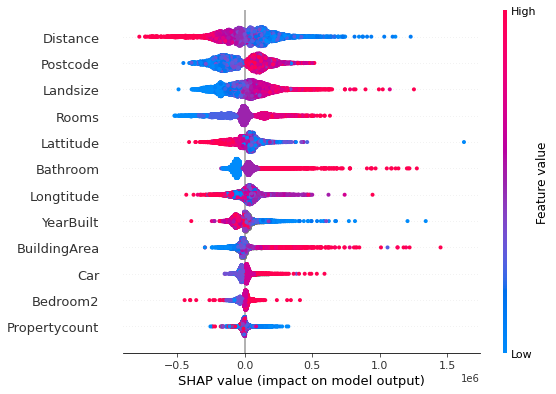

In [ ]:
shap.summary_plot(shap_values, X_train)

## Lightgbm

### Classification task

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [ ]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Regression task

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

lgbr = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42, n_jobs=-1)

scores = cross_val_score(lgbr, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [56.081 59.172 63.191 61.833 60.542]
RMSE mean: 60.164


In [ ]:
lgbr.fit(X,y)
lgbr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Speed

In [ ]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
lg_reg = lgb.LGBMClassifier(n_estimators=100, max_depth=2, random_state=42)

# Fit xg_reg to training set
lg_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = lg_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 7.302560567855835 seconds


### Hyperparameter

Following set of practices can be used to improve your model efficiency.

* **num_leaves** : This is the main parameter to control the complexity of the tree model. Ideally, the value of `num_leaves` should be less than or equal to 2^(max_depth). Value more than this will result in overfitting.

* **min_data_in_leaf** : Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

* **max_depth** : We also can use `max_depth` to limit the tree depth explicitly.

1. **For Faster Speed**

* Use bagging by setting `bagging_fraction` and `bagging_freq`.
* Use feature sub-sampling by setting `feature_fraction`.
* Use small `max_bin`.
* Use `save_binary` to speed up data loading in future learning.

2. **For better accuracy**

* Use large `max_bin` (may be slower).
* Use small `learning_rate` with `large num_iterations`
* Use large `num_leaves`(may cause over-fitting)
* Try to use categorical feature directly.

3. **To deal with over-fitting**

* Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to regularization
* Try `max_depth` to avoid growing deep tree
* Try `dart`

Check https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html for hyperparamter tuning.

### For categorical variable and missing value

LightGBM enables the missing value handle by default. See https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#missing-value-handle. It also deal with categorical variables as described here https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support

In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
for col in X_train_cat.columns:
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
lgbr = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42, n_jobs=-1)
lgbr.fit(X, y_train)

LGBMRegressor(random_state=42)

In [ ]:
preds = lgbr.predict(X_v)

In [ ]:
mean_absolute_error(y_valid, preds)

160267.37406568974

### SHAP values

In [ ]:
explainer = shap.Explainer(lgbr)
shap_values = explainer.shap_values(X)

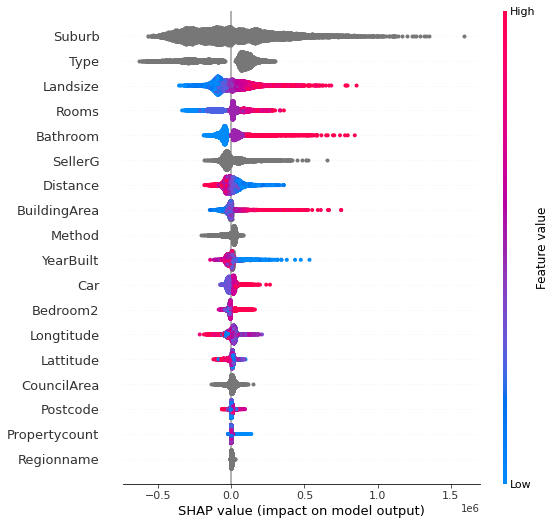

In [ ]:
shap.summary_plot(shap_values, X)

## CatBoost

In this section, we would explore some base cases of using catboost, such as model training, cross-validation and predicting

### Classification task

In [ ]:
iris = datasets.load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['target'])
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], random_state=42)

In [ ]:
clf = CatBoostClassifier(boosting_type='Plain', learning_rate=0.1, n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent')
clf.fit(X_train, y_train)

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_pred, y_test)
print('Score: ' + str(score))

Score: 1.0


In [ ]:
clf.get_all_params()

{'auto_class_weights': 'None',
 'bagging_temperature': 1,
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'border_count': 254,
 'class_names': [0, 1, 2],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'MultiClass',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 100,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10000000149011612,
 'loss_function': 'MultiClass',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 42,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': '

### Regression

In [ ]:
X,y = datasets.load_diabetes(return_X_y=True)

catb = CatBoostRegressor(boosting_type='Plain', learning_rate=0.1, random_state=42, n_estimators=100, thread_count=-1, logging_level = 'Silent')

scores = cross_val_score(catb, X, y, scoring='neg_mean_squared_error', cv=5)

# Take square root of the scores
rmse = np.sqrt(-scores)

# Display accuracy
print('RMSE:', np.round(rmse, 3))

# Display mean score
print('RMSE mean: %0.3f' % (rmse.mean()))

RMSE: [54.744 56.125 59.595 56.908 56.583]
RMSE mean: 56.791


In [ ]:
catb.fit(X,y)
catb.get_all_params()

{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': True,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'RMSE',
 'feature_border_type': 'GreedyLogSum',
 'force_unit_auto_pair_weights': False,
 'grow_policy': 'SymmetricTree',
 'iterations': 100,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 1,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.10000000149011612,
 'loss_function': 'RMSE',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'pool_metainfo_options': {'tags': {}},
 'posterior_sampling': False,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fractio

### Speed

In [ ]:
df = pd.read_csv('exoplanets.csv')
# Split data into X and y
X = df.iloc[:,1:]
y = df.iloc[:,0]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
start = time.time()

# Instantiate the XGBRegressor, xg_reg
ca_reg = CatBoostClassifier(n_estimators=100, max_depth=2, random_state=42, logging_level = 'Silent')

# Fit xg_reg to training set
ca_reg.fit(X_train, y_train)

# Predict labels of test set, y_pred
y_pred = ca_reg.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('Score: ' + str(score))

end = time.time()
elapsed = end - start

print('Run Time: ' + str(elapsed) + ' seconds')

Score: 0.9913522012578616
Run Time: 15.904590129852295 seconds


### Hyperparameter

You can check more details at https://catboost.ai/en/docs/references/training-parameters/. There are also tutorials about hyperparameter tuning https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning_using_optuna_and_hyperopt.ipynb

### For categorical variable and missing value

One of the differences between CatBoost and other gradient boosting libraries is its advanced processing of the categorical features (in fact "Cat" in the package name stands for "CATegorical").

CatBoost deals with the categorical data quite well out-of-the-box. However, it also has a huge number of training parameters, which provide fine control over the categorical features preprocessing.

The amount of parameters related to categorical features processing in CatBoost is overwhelming. Here is a hopefully the full list:

* `one_hot_max_size` (int) - use one-hot encoding for all categorical features with a number of different values less than or equal to the given parameter value. No complex encoding is performed for such features. 

* `model_size_reg` (float from 0 to inf) - The model size regularization coefficient. The larger the value, the smaller the model size. This regularization is needed only for models with categorical features (other models are small). Models with categorical features might weight tens of gigabytes or more if categorical features have a lot of values. If the value of the regularizer differs from zero, then the usage of categorical features or feature combinations with a lot of values has a penalty, so fewer of them are used in the resulting model. Default value is 0.5

* `max_ctr_complexity` - The maximum number of features that can be combined. Each resulting combination consists of one or more categorical features and can optionally contain binary features in the following form: “numeric feature > value”. For regression task on CPU the default value is 4.

* `has_time (bool)` - if true, the 1-st step of categorical features processing, permutation, is not performed. Useful when the objects in your dataset are ordered by time. For our dataset, we don't need it. Default value is False

* `simple_ctr` - Quantization settings for simple categorical features.
combinations_ctr - Quantization settings for combinations of categorical features.

* `per_feature_ctr` - Per-feature quantization settings for categorical features.

* `counter_calc_method` determines whether to use validation dataset (provided through parameter eval_set of fit method) to estimate categories frequencies with Counter. By default, it is Full and the objects from validation dataset are used; Pass SkipTest value to ignore the objects from the validation set
ctr_target_border_count - The maximum number of borders to use in target quantization for categorical features that need it. Default for regression task is 1.

* `ctr_leaf_count_limit` - The maximum number of leaves with categorical features. Default value is None i.e. no limit.

* `store_all_simple_ctr`- If the previous parameter ctr_leaf_count_limit at some point gradient boosting tree can no longer make splits by categorical features. With Default value False the limitation applies both to original categorical features and the features, that CatBoost creates by combining different features. If this parameter is set to True only the number of splits made on combination features is limited.

The three parameters `simple_ctr`, `combinations_ctr`, and `per_feature_ctr` are complex parameters that control the second and the third steps of categorical features processing.

In [ ]:
# Select target
data = pd.read_csv('melb_data.csv')
y = data.Price

# To keep things simple, we'll split the columns into numerical can categorical features
melb_predictors = data.drop(['Price', 'Date', 'Address'], axis=1)
cat_col = melb_predictors.select_dtypes(exclude=['int64','float64'])

# Divide data into training and validation subsets
X, X_v, y_train, y_valid = train_test_split(melb_predictors, y, train_size=0.8, test_size=0.2, random_state=0)
X_train = X.select_dtypes(exclude=['object'])
X_valid = X_v.select_dtypes(exclude=['object'])
X_train_cat = X.select_dtypes(exclude=['int64','float64'])
X_valid_cat = X_v.select_dtypes(exclude=['int64','float64'])

In [ ]:
categorical_features_names = list(X_train_cat.columns)

for col in categorical_features_names:
  X[col] = X.loc[:,col].fillna(value='nan')
  X_v[col] = X_v.loc[:,col].fillna(value='nan')
  X[col] = X[col].astype('category')
  X_v[col] = X_v[col].astype('category')

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

In [ ]:
preds = catbr.predict(X_v)

In [ ]:
mean_absolute_error(y_valid, preds)

164721.46472522244

The first thing we try is to make CatBoost use one-hot encoding for all our categorical features. The documentation says, that for the features for which one-hot encoding is used no other encodings are computed.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, one_hot_max_size=500)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163165.1377008556

Let us try to set model size regularization coefficient to 0 - thus we allow our model to use as many categorical features and its combinations as it wants.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

165007.46639148306

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, model_size_reg=1)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

160827.54657606702

Note that any combination of several categorical features could be considered as a new one. Although it is not mentioned in the documentation, this parameter value has to be smaller than 15.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=6)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

163529.3517553931

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, max_ctr_complexity=0)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164721.46472522244

Counter method is very similar to the traditional Frequency Encoding

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Counter', combinations_ctr='Counter')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

164993.47954656056

Now we proceed to the settings of the encodings methods that require target quantization. The first choice is `Borders` vs. Buckets

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Borders', combinations_ctr='Borders')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166920.94141120723

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, simple_ctr='Buckets', combinations_ctr='Buckets')
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

168168.9386958123

It is quite common to use several encodings for a categorical feature. For instance, CatBoost creates 4 different encodings for each categorical feature by default. By default, CatBoost uses several encoding techniques to encode each categorical feature.

* First it uses `Borders` method with one target border `TargetBorderCount=1` (in our example for each categorical feature we just want to see if it makes the car more expensive). The obtained float encodings are further discretized into `CtrBorderCount=15` different values. Three values of Prior parameter are used to create 3 three different encodings: `Prior=0/1:Prior=0.5/1:Prior=1/1`

* Also for each categorical feature, we create an encoding with Counter method. The number of categorical encoding value borders `CtrBorderCount` is also equal to 15, and only one value of `Prior=0/1` is used.

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names, ctr_target_border_count=10)
catbr.fit(X, y_train)
preds = catbr.predict(X_v)
mean_absolute_error(y_valid, preds)

166281.68070428775

In [ ]:
catbr = CatBoostRegressor(n_estimators=100, random_state=42, thread_count=-1, logging_level = 'Silent', cat_features=categorical_features_names)
catbr.fit(X, y_train)

### SHAP values

In [ ]:
explainer = shap.Explainer(catbr)
shap_values = explainer(X)

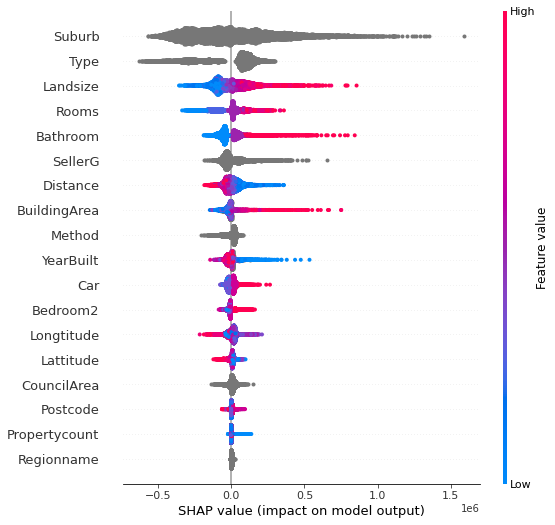

In [ ]:
shap.summary_plot(shap_values, X)